In [1]:
from unicodedata import name
from matplotlib import pyplot as plt
from matplotlib import collections  as mc
import random
import math
import pandas as pd
import runExpeStoc
import generateData
import generateSimpleData
from classes.utils import Utils
from classes.plotting import Plotting

#random.seed(123)

num_i = 10
num_a = 2
num_b = 2
num_c = 3
num_h = 2
num_t = 1
num_selfEva = 1
numClas = 1
numScenarios = 2
upperTimeLimit = 100
T = upperTimeLimit
penalty = 200
evaDemand = [100,151]
evaDemand = [math.floor(ed/num_a) for ed in evaDemand]
objFunction = {
    1 : 'bal_1',
    2 : 'econ_1'
}

params = dict()
params['upperTimeLimit'] = upperTimeLimit
params['penalty'] = penalty
params['objFunction'] = objFunction[1]
m = 0
params['percentToEva'] = m
if m == 0:
    params['force_eva_percent'] = False
else:
    params['force_eva_percent'] = True

=========Creating nodes=========
=========End creating nodes=========
=========Populationg scenarios=========
=========End creating Scenarios=========
=========Creating resources=========
=========End creating resources=========
=========Computing k values=========
=========End computing k values=========
=========Creating Arcs=========
=========End creating arcs=========
=========Start writing data=========
=========End writing data=========


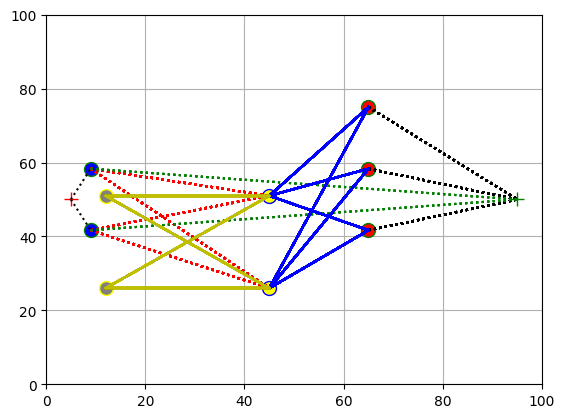

In [2]:
data = generateData.generateData(num_i, num_a, num_h, num_b, num_c, num_selfEva, evaDemand, numClas, numScenarios)

plotting = Plotting(data)
plotting.plotBase()
plotting.plotResourceArcs()


In [3]:
status, runtime, objVal, experiment = runExpeStoc.runExpeStochastic(data, params)



Set parameter Username
Academic license - for non-commercial use only - expires 2023-09-16
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 5160 rows, 2800 columns and 21930 nonzeros
Model fingerprint: 0x6773bb7a
Variable types: 10 continuous, 2790 integer (1410 binary)
Coefficient statistics:
  Matrix range     [5e-02, 6e+01]
  Objective range  [3e-07, 6e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 6e+01]
Presolve removed 4790 rows and 2455 columns
Presolve time: 0.02s
Presolved: 370 rows, 345 columns, 2384 nonzeros
Variable types: 0 continuous, 345 integer (120 binary)
Found heuristic solution: objective 23000.000000
Found heuristic solution: objective 22039.773235

Root relaxation: objective 2.291244e+02, 467 iterations, 0.01 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | 

In [4]:
df = pd.DataFrame(columns=['probability', 'severity', 'speedCoeff', 'loadingCoeff', 'maxRounTrips'])
scenarios = data['scenarios']
probabilities = [sc.probability for sc in scenarios]
df['probability'] = probabilities
severities = [sc.severity for sc in scenarios]
speedCoeffs = [sc.speedCoeff for sc in scenarios]
loadCoeffs = [sc.loadingCoeff for sc in scenarios]
notEva, key = Utils.getVars(Utils, experiment.getVars(), 'numNotEva_mean')

df['severity'] = severities
df['speedCoeff'] = speedCoeffs
df['loadingCoeff'] = loadCoeffs
df['maxRounTrips'] = [sc.num_k for sc in scenarios]
df['Not Evacuated'] = [abs(ne) for ne in notEva]
df['Penalty'] = [penalty] + ['']*(numScenarios-1)

df

,probability,severity,speedCoeff,loadingCoeff,maxRounTrips,Not Evacuated,Penalty
0,0.322731,2,0.623269,1.376731,2,0.0,200
1,0.214197,2,0.694444,1.305556,2,0.0,
2,0.099638,1,0.937500,1.062500,2,0.0,
3,0.313534,2,0.694444,1.305556,2,0.0,
4,0.049900,1,0.909091,1.090909,2,0.0,


In [5]:
df = pd.DataFrame(columns=['is_in_fleet', 'Time mins', 'MeanVarCost €', 'FixedCost €'])
isResInFleet, key = Utils.getVars(Utils, experiment.getVars(), 'isResInFleet')
meanTimeForResourceI , key = Utils.getVars(Utils, experiment.getVars(), 'meanTimeForResourceI')



meanTimeForResourceI = [math.floor(mt * 100)/100 for mt in meanTimeForResourceI]
costs = []
fixedCosts = []
for i in range(num_i):
    costs.append( data['resources'][i].varCost * meanTimeForResourceI[i])
    fixedCosts.append(data['resources'][i].fixedCost)
df['is_in_fleet'] = [math.floor(abs(rs)) for rs in isResInFleet]
df['Time mins'] = [math.floor(mt * 100)/100 for mt in meanTimeForResourceI]
df['MeanVarCost €'] = costs
df['FixedCost €'] = fixedCosts

df

,is_in_fleet,Time mins,MeanVarCost €,FixedCost €
0,0,183.00,1372.50,50000
1,0,183.00,3568.50,130000
2,0,183.00,1098.00,40000
3,0,183.00,3019.50,110000
4,0,183.00,1372.50,50000
5,1,230.84,6578.94,190000
6,0,183.00,1098.00,40000
7,0,183.00,3843.00,140000
8,0,183.00,1372.50,50000
9,1,269.04,5246.28,130000
